# Zooplankton biomass

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client
import numpy as np
import catalog
import util
import pandas as pd
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT

### Parameters

In [5]:
casename = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'
component = 'pop'
stream = 'h'

cluster_scheduler_address = None

In [6]:
assert component in ['pop']
assert stream in ['h', 'h.ecosys.nday1']

### Connect to cluster

In [7]:
if cluster_scheduler_address is None:
    cluster, client = util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35720 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/35720/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/35720/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:43563,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/35720/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data

In [8]:
dsets = catalog.to_dataset_dict(
    case=casename,
    component=component,
    stream=stream,
)
dsets.keys()

dict_keys(['g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1.pop.h'])

In [9]:
ds = dsets[f'{casename}.{component}.{stream}']

### Variable list

In [10]:
variables =['mesozooC', 'microzooC']

In [11]:
keep_vars=['z_t','z_t_150m','dz','time_bound','time','TAREA','TLAT','TLONG'] + variables
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### Make a monthly climatology dataset

In [12]:
time = pd.date_range(start="2009-01-01", end="2019-01-01",freq="M")

In [13]:
mon_ds = ds.copy()
mon_ds['time'] = time
mon_ds = ds.groupby('time.month').mean('time')

### Compute long-term mean

In [14]:
ds = ds.mean(dim='time')

### Plot mesozooplankton and microzooplankton biomass at the surface

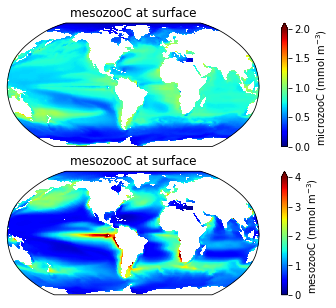

In [15]:
###### 
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('microzooC at surface', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.microzooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='microzooC (mmol m$^{-3}$)')


ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('mesozooC at surface', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.mesozooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mesozooC (mmol m$^{-3}$)')

### Compare mesozooplankton biomass to COPEPOD database

[Moriarty & O'Brien, 2013](https://essd.copernicus.org/articles/5/45/2013/essd-5-45-2013.pdf)

In [16]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file, consolidated=False)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

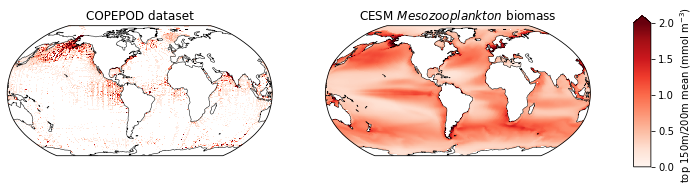

In [17]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds_copepod.copepod_C)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.mesozooC.mean(dim='z_t_150m'))
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)');

### Compare to observation-based GLMM of global mesozooplankton biomass climatology 
[Heneghan et al., 2020](https://www.sciencedirect.com/science/article/abs/pii/S0304380020303355)

[Petrik et al., submitted to Global Biogeochemical Cycles](https://www.essoar.org/doi/abs/10.1002/essoar.10510705.1)

In [18]:
file = '/glade/u/home/kristenk/work/copepod-biomass/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod_clim = xr.open_dataset(file)
ds_copepod_clim.zmeso200.attrs['units'] = 'mgC m-2'

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [19]:
### depth integrate and convert model to mol/m2
mon_ds['mesozooC_zint'] = ((mon_ds.mesozooC) * 10.).sum(dim='z_t_150m') #in mmol/m2
mon_ds['mesozooC_zint'] = mon_ds['mesozooC_zint'] * 12.011 #convert to mgC/m2
mon_ds['mesozooC_zint'].attrs['units'] = 'mgC m-2'

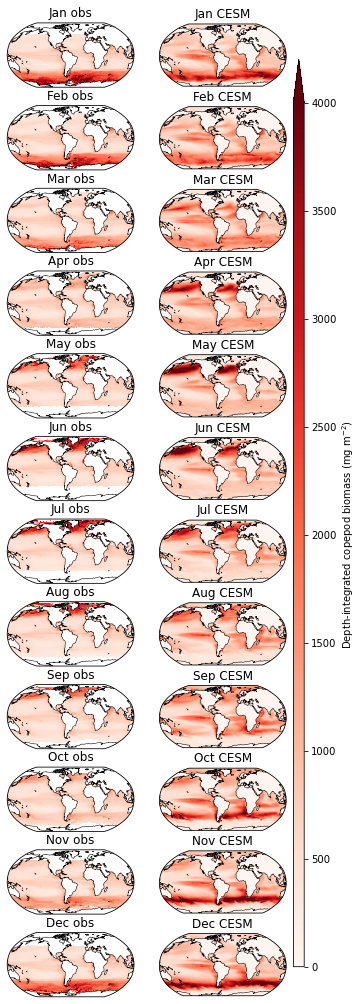

In [20]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' obs', fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), 
                     cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' CESM', fontsize=12)
    tmp = mon_ds.mesozooC_zint.isel(month=ts)
    lon, lat, field = util.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mg m$^{-2}$)');

### **TO DO** 
• Additional comparisons to make (Colleen's suggestions): look at the seasonal cycle in different regions and also the relationship between zooplankton biomass and chlorophyll. 

• Add production fields

• z-ratio comparison

• Comparisons to MAREDAT